In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from synthetic_datasets import BatchedInContextRecallDataset
from meta_optimizers import MetaSGD
from memory_module import inner_optimization_forward, TTT
from model_components import HyperparamModel, LearnableHyperparam
from evaluate import compute_recall_accuracies, correct_retrieval_counts_by_timestep, average_accuracy_by_offset

In [38]:
key_dim=20
val_dim=20
context_size=10 # inner loss computation window
seq_len=100
batch_size=500
output_corr=0
inner_optimizer=MetaSGD()
#inner_optimizer_kwargs={ "beta": torch.tensor(0.9)}
#outer_optimizer_kwargs={"lr": 0.01}

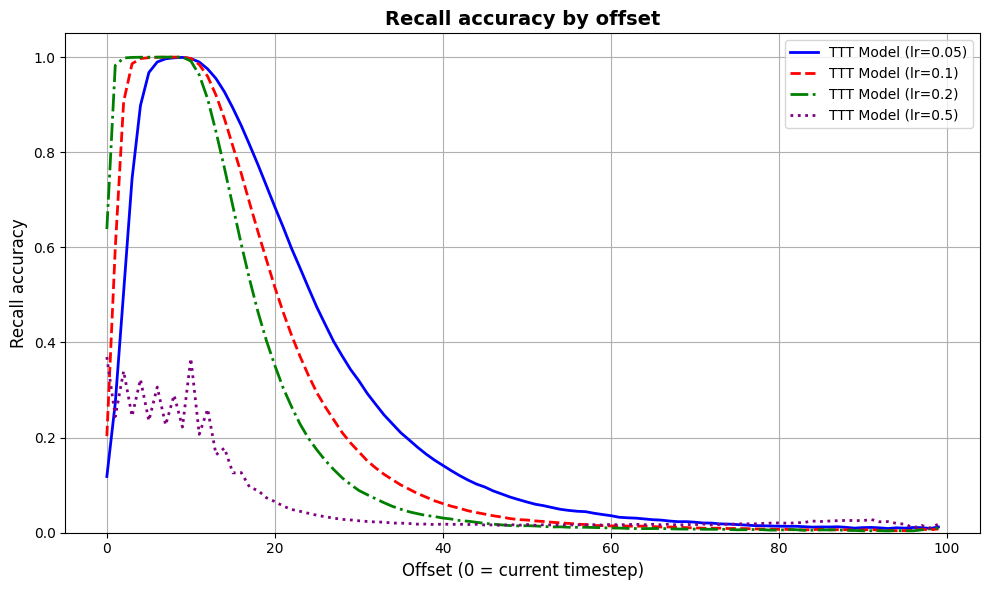

In [41]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dataset = BatchedInContextRecallDataset(
    seq_len=seq_len,
    key_dim=key_dim,
    val_dim=val_dim,
    context_size=context_size,
    batch_size=batch_size,
)    

learning_rates = [0.05, 0.1, 0.2, 0.5]
results = {}

for lr in learning_rates:

    _, predictions = inner_optimization_forward(
        memory_module=TTT(key_dim,val_dim,1, 0.0).to(device),
        dataset=dataset.to(device),
        inner_opt=inner_optimizer,
        lr_head=lr,
        loss_weight_head=torch.ones(context_size).to(device),
        eval_mode=True
    )

    accuracies = compute_recall_accuracies(predictions,dataset.targets)
    accuracy_by_offset, count = average_accuracy_by_offset(accuracies)

    # Store results
    results[lr] = accuracy_by_offset.to("cpu")

plt.figure(figsize=(10, 6))

# Define colors and line styles for each learning rate
colors = ['blue', 'red', 'green', 'purple']
line_styles = ['-', '--', '-.', ':']

for i, lr in enumerate(learning_rates):
    offsets = np.arange(len(results[lr]))
    plt.plot(offsets, results[lr], 
             color=colors[i], 
             linestyle=line_styles[i], 
             linewidth=2, 
             label=f'TTT Model (lr={lr})')

# Plot average accuracy by offset
plt.xlabel("Offset (0 = current timestep)", fontsize=12)
plt.ylabel("Recall accuracy", fontsize=12)
plt.title("Recall accuracy by offset", fontsize=14, fontweight='bold')
plt.ylim(0.0, 1.05)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()